# Imports and constants

In [102]:
import subprocess
import os
import sys

PROJECT_ROOT = os.path.dirname(os.path.abspath(__file__)) if '__file__' in globals() else os.getcwd()

bids_dir = os.path.join(PROJECT_ROOT, "data")
output_dir = os.path.join(PROJECT_ROOT, "output")
fs_license = os.path.join(PROJECT_ROOT, "license.txt")
work_dir = os.path.join(PROJECT_ROOT, "work")
subject = "101410"

from nilearn import plotting, masking, image
from nilearn.image import math_img, concat_imgs, resample_to_img
from nipype.interfaces import fsl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import pandas as pd


In [80]:
data_folder = 'data'
fmri_data_dir = os.path.join(data_folder, 'fMRI')
fmri_output_dir = os.path.join(output_dir, 'fmri')
os.makedirs(fmri_output_dir, exist_ok=True)

t1w_file = os.path.join(data_folder, 'T1w/T1w.nii.gz')

try:
    result = subprocess.run(['ls', '-R', bids_dir], 
                            capture_output=True, 
                            text=True, 
                            check=True)
    print(result.stdout)

except subprocess.CalledProcessError as e:
    print(f"Error checking directory: {e.stderr}")
except FileNotFoundError:
    print("Error: 'ls' command not found.")

T1w
dataset_description.json
dataset_description.md
fMRI
task-motor_bold.json

/Users/bui/code/NX-421-project/data/T1w:
T1w.nii.gz

/Users/bui/code/NX-421-project/data/fMRI:
tfMRI_MOTOR_LR
tfMRI_MOTOR_RL

/Users/bui/code/NX-421-project/data/fMRI/tfMRI_MOTOR_LR:
events_LR.csv
tfMRI_MOTOR_LR.nii

/Users/bui/code/NX-421-project/data/fMRI/tfMRI_MOTOR_RL:
events_RL.csv
tfMRI_MOTOR_RL.nii



# Structural preprocessing

## Original brain plot

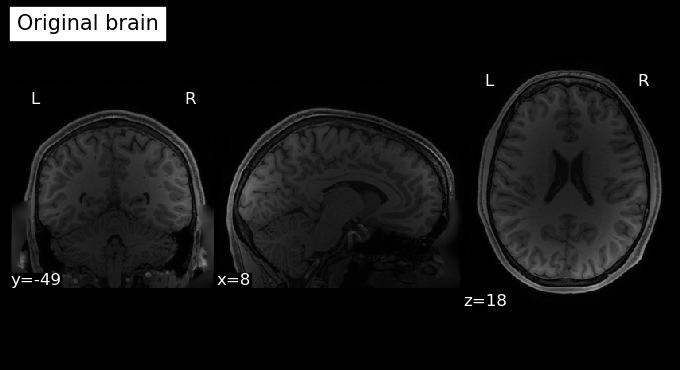

In [35]:
display = plotting.plot_anat(
    t1w_file,
    title='Original brain',
    display_mode='ortho',
    draw_cross=False,
)

plotting.show()

### Using Nilearn

In [24]:
t1w_img = image.load_img(t1w_file)

print("Computing brain mask...")
brain_mask_img = masking.compute_brain_mask(t1w_img,
                                          threshold=0.5,
                                          opening=2,
                                          connected=True)

print("Applying mask to T1w image...")
skull_stripped_img = image.math_img("img1 * img2",
                            img1=t1w_img,
                            img2=brain_mask_img)   

output_dir = "output"
os.makedirs(output_dir, exist_ok=True)
skull_stripped_img_path = os.path.join(output_dir, "t1w_nilearn_skullstripped.nii.gz")
skull_stripped_img.to_filename(skull_stripped_img_path)
print(f"Skull-stripped image saved to {skull_stripped_img_path}")


Computing brain mask...
Applying mask to T1w image...
Skull-stripped image saved to output/t1w_nilearn_skullstripped.nii.gz


### Using BET

In [ ]:
out_1_default = os.path.join(output_dir, 't1w_brain_1.nii.gz')
out_2_robust = os.path.join(output_dir, 't1w_brain_2_robust.nii.gz')
out_3_generous = os.path.join(output_dir, 't1w_brain_3_generous.nii.gz')
out_4_bias_correct = os.path.join(output_dir, 't1w_brain_4_robust_bias.nii.gz')
out_5 = os.path.join(output_dir, 't1w_brain_5.nii.gz')
out_6 = os.path.join(output_dir, 't1w_brain_6.nii.gz')

# print("Running Command 1 (Default)...")
# !bet {t1w_file} {out_1_default} -f 0.5

# # Command 2: Robust mode (from your example)
# print("Running Command 2 (Robust)...")
# !bet {t1w_file} {out_2_robust} -f 0.5 -R

# # Command 3: Generous (larger) brain
# print("Running Command 3 (Generous)...")
# !bet {t1w_file} {out_3_generous} -f 0.2

# # Command 4: Robust + Bias Correction + Mask
# print("Running Command 4 (Robust, Bias-Corrected, Mask)...")
# !bet {t1w_file} {out_4_bias_correct} -f 0.5 -B -m

# print("Running Command 5")
# !bet {t1w_file} {out_5} -f 0.5 -g 0.1

print("Running Command 6")
!bet {t1w_file} {out_6} -f 0.5 -g 0.2

Running Command 6


## Skull stripped brain plot

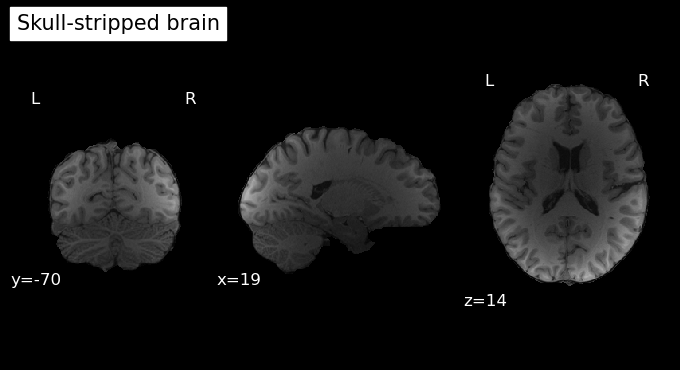

In [43]:
skull_stripped_file = out_5

display = plotting.plot_anat(
    skull_stripped_file,
    title='Skull-stripped brain',
    display_mode='ortho',
    draw_cross=False,
)
plotting.show()


## Segmentation

In [42]:
fast = fsl.FAST()
fast.inputs.in_files = skull_stripped_file

fast.inputs.img_type = 1
fast.inputs.number_classes = 3 # Segment into GM, WM, and CSF
fast.inputs.probability_maps = True
fast.inputs.output_type = 'NIFTI_GZ'

result = fast.run() # note: takes about 4 minutes to run
print("FAST segmentation finished.")

FAST segmentation finished.


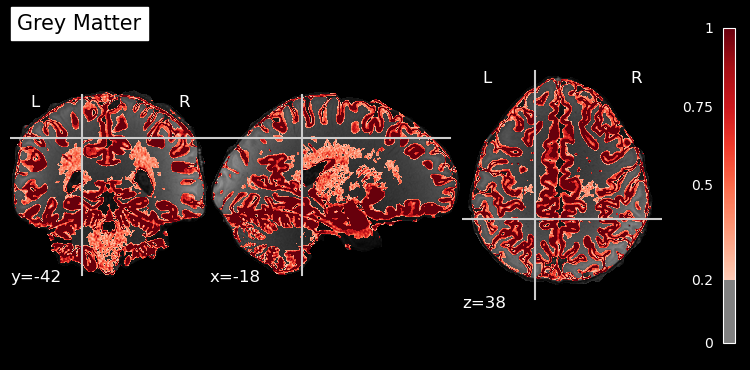

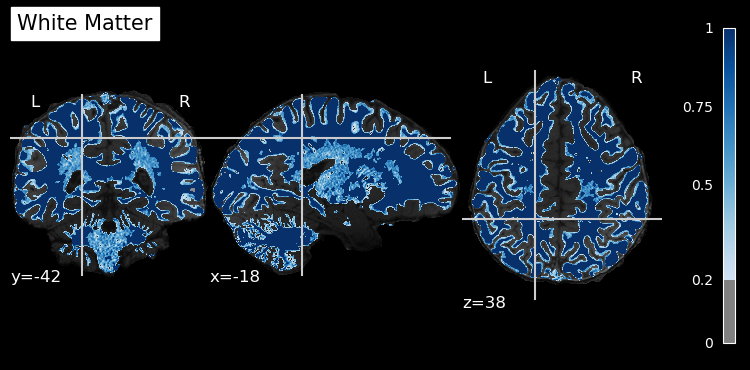

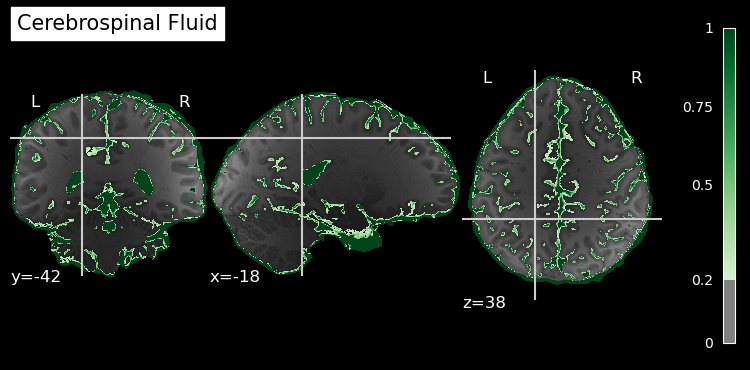

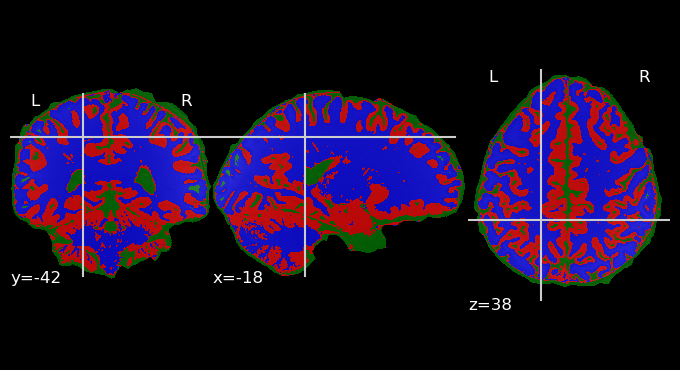

In [62]:
skull_stripped_file = os.path.join(output_dir, 't1w_brain_3_generous.nii.gz')
base_name = os.path.basename(skull_stripped_file).split('.')[0]

bg_img = image.load_img(skull_stripped_file)

csf_pve_file = os.path.join(output_dir, f"{base_name}_pve_0.nii.gz")
gm_pve_file = os.path.join(output_dir, f"{base_name}_pve_1.nii.gz")
wm_pve_file = os.path.join(output_dir, f"{base_name}_pve_2.nii.gz")

csf_img = image.load_img(csf_pve_file)
gm_img = image.load_img(gm_pve_file)
wm_img = image.load_img(wm_pve_file)

seg_file = os.path.join(output_dir, f"{base_name}_seg.nii.gz")
seg_img = image.load_img(seg_file)

cut_coords = (-18.53492, -42.50713, 38.89582)

plotting.plot_stat_map(gm_img,
                         bg_img=bg_img,
                         title='Grey Matter',
                         cut_coords=cut_coords,
                         display_mode='ortho',
                         cmap='Reds',
                         threshold=0.2) # Only show voxels > 20% probability

plotting.plot_stat_map(wm_img,
                         bg_img=bg_img,
                         title='White Matter',
                         cut_coords=cut_coords,
                         display_mode='ortho',
                         cmap='Blues',
                         threshold=0.2)     

plotting.plot_stat_map(csf_img,
                         bg_img=bg_img,
                         title='Cerebrospinal Fluid',
                         cut_coords=cut_coords,
                         display_mode='ortho',
                         cmap='Greens',
                         threshold=0.2)

custom_cmap = ListedColormap(['green', 'red', 'blue'])

plotting.plot_roi(seg_img,
                  bg_img=bg_img,
                  cut_coords=cut_coords,
                  display_mode='ortho',
                  annotate=True,
                  draw_cross=True,
                  cmap=custom_cmap)

plotting.show()

# Functional preprocessing

In [82]:
base_name = 't1w_brain_3_generous'
stripped_file = os.path.join(output_dir, f"{base_name}.nii.gz")

mask_file_to_create = os.path.join(output_dir, f"{base_name}_mask.nii.gz")
generous_img = image.load_img(stripped_file)
mask_img = math_img("img > 0", img=generous_img)
mask_img.to_filename(mask_file_to_create)

print(f"Mask file saved to: {mask_file_to_create}")

mask_file = mask_file_to_create

run_lr_file = os.path.join(fmri_data_dir, 'tfMRI_MOTOR_LR', 'tfMRI_MOTOR_LR.nii')
run_rl_file = os.path.join(fmri_data_dir, 'tfMRI_MOTOR_RL', 'tfMRI_MOTOR_RL.nii')

concatenated_file = os.path.join(fmri_output_dir, 'tfMRI_MOTOR_concatenated.nii.gz')

Mask file saved to: /Users/bui/code/NX-421-project/output/t1w_brain_3_generous_mask.nii.gz


## Concatenate all runs

In [ ]:
def scale_run(fmri_file, mask_file):    
    fmri_img = image.load_img(fmri_file)
    mask_img = image.load_img(mask_file)
    resampled_mask_img = resample_to_img(
        source_img=mask_img,
        target_img=fmri_img,
        interpolation='nearest'
    )
    brain_timeseries = masking.apply_mask(fmri_img, resampled_mask_img)
    global_std = np.std(brain_timeseries, ddof=1) # ddof=1 for an unbiased estimate
    print(f"  ...Global STD found: {global_std:.4f}")
    scaled_img = math_img(f"img / {global_std}", img=fmri_img)
    
    return scaled_img

scaled_lr_img = scale_run(run_lr_file, mask_file)
scaled_rl_img = scale_run(run_rl_file, mask_file)

concatenated_img = concat_imgs([scaled_lr_img, scaled_rl_img])
concatenated_img.to_filename(concatenated_file)

print(f"Concatenated file saved to: {concatenated_file}")
print(f"  ...Original shape (LR): {scaled_lr_img.shape}")
print(f"  ...Original shape (RL): {scaled_rl_img.shape}")
print(f"  ...New concatenated shape: {concatenated_img.shape}")

/var/folders/gs/vcnb5f6s7fj7nkdhj2hwrrmr0000gn/T/ipykernel_95113/562157825.py:4: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask_img = resample_to_img(
/Users/bui/anaconda3/envs/NX-421/lib/python3.12/site-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


  ...Global STD found: 3548.5125


/var/folders/gs/vcnb5f6s7fj7nkdhj2hwrrmr0000gn/T/ipykernel_95113/562157825.py:4: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask_img = resample_to_img(
/Users/bui/anaconda3/envs/NX-421/lib/python3.12/site-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


  ...Global STD found: 3495.4268
Concatenated file saved to: /Users/bui/code/NX-421-project/output/fmri/tfMRI_MOTOR_concatenated.nii.gz
  ...Original shape (LR): (91, 109, 91, 284)
  ...Original shape (RL): (91, 109, 91, 284)
  ...New concatenated shape: (91, 109, 91, 568)


## Motion Correction

In [ ]:
concatenated_file = os.path.join(fmri_output_dir, 'tfMRI_MOTOR_concatenated.nii.gz')

mc_file = os.path.join(fmri_output_dir, 'tfMRI_MOTOR_mc')

mcflirt = fsl.MCFLIRT()
mcflirt.inputs.in_file = concatenated_file
mcflirt.inputs.out_file = mc_file 
mcflirt.inputs.save_plots = True
mcflirt.inputs.mean_vol = True
mcflirt.inputs.stats_imgs = True

try:
    print("Running motion correction (takes around 2-3 min)...")
    result = mcflirt.run()
    mc_file = result.outputs.out_file
    param_file = result.outputs.par_file
    print("Motion correction finished (Nipype successful).")

except FileNotFoundError as e:
    print(f"\n--- Nipype bug encountered ---")
    print(f"Error: {e}")
    print("Ignoring error bcs FSL has a freaking bug")
    
    param_file = mc_file + ".par"
    mc_file = mc_file + ".nii.gz"
    
    if not os.path.exists(mc_file) or not os.path.exists(param_file):
        print("\n---!!! FATAL ERROR !!!---")
        print(f"FSL files not found at: \n{mc_file}\n{param_file}")
        print("The FSL command *actually* failed. Check FSL installation.")
    else:
        print("Motion correction finished (files found manually).")

print(f"\nMotion file created at: {mc_file}")
print(f"Motion parameters saved to: {param_file}")

Running motion correction (takes around 2-3 min)...

--- Nipype bug encountered ---
Error: No such file or directory '/Users/bui/code/NX-421-project/output/fmri/tfMRI_MOTOR_mc' for output 'out_file' of a MCFLIRT interface
Ignoring error bcs FSL has a freaking bug

---!!! FATAL ERROR !!!---
FSL files not found at: 
/Users/bui/code/NX-421-project/output/fmri/tfMRI_MOTOR_mc.nii.gz
/Users/bui/code/NX-421-project/output/fmri/tfMRI_MOTOR_mc.nii.gz.par
The FSL command *actually* failed. Check FSL installation.

Motion file created at: /Users/bui/code/NX-421-project/output/fmri/tfMRI_MOTOR_mc.nii.gz
Motion parameters saved to: /Users/bui/code/NX-421-project/output/fmri/tfMRI_MOTOR_mc.nii.gz.par


In [100]:
mc_file = os.path.join(fmri_output_dir, 'tfMRI_MOTOR_mc.nii.gz')
param_file = os.path.join(fmri_output_dir, 'tfMRI_MOTOR_mc.par')

Plotting FD...


/var/folders/gs/vcnb5f6s7fj7nkdhj2hwrrmr0000gn/T/ipykernel_95113/3071630027.py:15: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  mot_params_df = pd.read_csv(param_file, sep='  ', header=None,


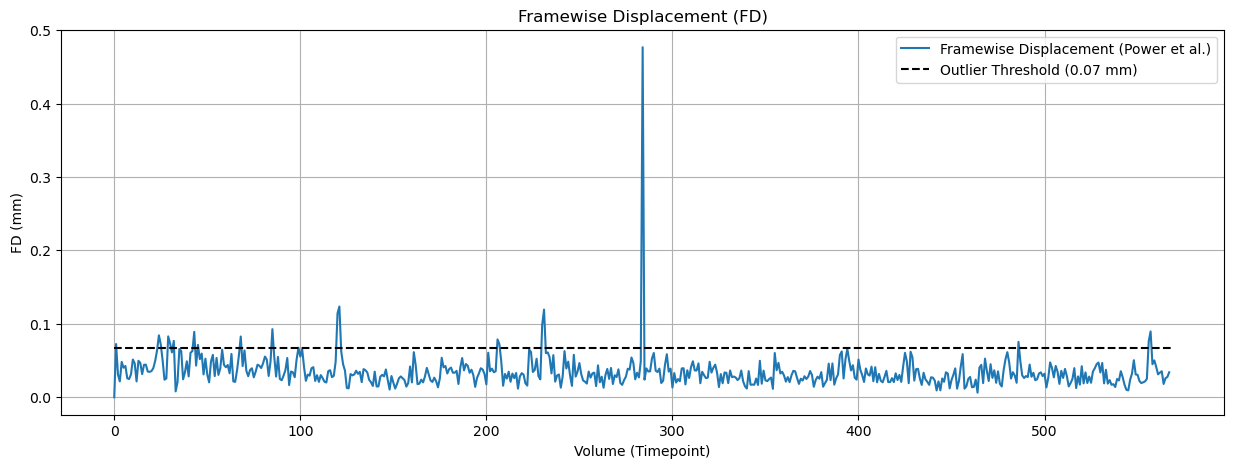


--- Motion Statistics ---
Max FD: 0.4767 mm
Mean FD: 0.0349 mm
Volumes exceeding threshold (FD > 0.07 mm): 21


In [103]:
def compute_FD_power(mot_params_df):
    """Calculates FD from a DataFrame (assumes rotations are in RADIANS)"""
    framewise_diff = mot_params_df.diff().iloc[1:]
    
    rot_params = framewise_diff[['Rotation x', 'Rotation y', 'Rotation z']]
    # Convert radians to mm on a 50mm radius sphere
    converted_rots = rot_params * 50
    
    trans_params = framewise_diff[['Translation x', 'Translation y', 'Translation z']]
    
    # Sum the absolute values (L1 norm)
    fd = converted_rots.abs().sum(axis=1) + trans_params.abs().sum(axis=1)
    return fd.to_numpy()

mot_params_df = pd.read_csv(param_file, sep='  ', header=None,
                            names=['Rotation x', 'Rotation y', 'Rotation z', 
                                   'Translation x', 'Translation y', 'Translation z'])

fd = compute_FD_power(mot_params_df)
fd = np.insert(fd, 0, 0)

print("Plotting FD...")

# Calculate the outlier threshold (IQR method)
q75, q25 = np.quantile(fd, [0.75, 0.25])
iqr = q75 - q25
threshold = q75 + 1.5 * iqr

plt.figure(figsize=(15, 5))
plt.plot(fd, label='Framewise Displacement (Power et al.)')
plt.hlines(threshold, 0, len(fd), colors='black', linestyles='dashed', label=f'Outlier Threshold ({threshold:.2f} mm)')
plt.title('Framewise Displacement (FD)')
plt.xlabel('Volume (Timepoint)')
plt.ylabel('FD (mm)')
plt.legend()
plt.grid(True)
plt.show()

print(f"\n--- Motion Statistics ---")
print(f"Max FD: {np.max(fd):.4f} mm")
print(f"Mean FD: {np.mean(fd):.4f} mm")
print(f"Volumes exceeding threshold (FD > {threshold:.2f} mm): {np.sum(fd > threshold)}")